In [2]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from wordcloud import WordCloud
from tensorflow.keras import layers,models,losses, Sequential, optimizers, metrics


In [3]:
tweets_data = pd.read_csv('Tweets.csv')
tweets_data.sample(10)

,textID,text,selected_text,sentiment
10832,d9952724c1,yeeeeeessss I can`t wait! Too bad I can`t drink,Too bad,negative
2885,df5bd277ca,wishes he can just call her. blah. it used to...,wtf happened?,negative
22436,cf3fce5180,i am so stressed and sad about pugsly missing....,i am so stressed and sad about pugsly missing.,negative
5251,ef2ab041f3,Is there going to be any more TAI TV? Ah I h...,Is there going to be any more TAI TV? Ah I hop...,neutral
19223,f227d3770a,"It is so miserably hot, the a/c in my house is...","miserably hot,",negative
8372,34b6e311bd,have to go now by`all <3 see ya later guys ****,have to go now by`all <3 see ya later guys ****,neutral
6392,3da077e314,_Molecule where is Sackiroth,_Molecule where is Sackiroth,neutral
23383,f10c4c2d42,just stop talking if ur gonna be that mean,mean,negative
22052,afa6bbf109,_RedBone stop that babe u makin me feel very b...,feel very bad,negative
9520,4f8a0ed33a,DUDE WHAT? I WANNNNAAAA GOOOOOO,DUDE WHAT? I WANNNNAAAA GOOOOOO,neutral


In [4]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
tweets_data= tweets_data.dropna()
tweets_data.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [6]:
tweets_data.duplicated().sum()

0

In [7]:
# tweets_data = tweets_data.drop(columns=["selected_text","textID"])
tweets_data.sample(10)

,textID,text,selected_text,sentiment
19619,9b0fb70c3c,Life Just Isn`t Fair > And I Feel,Life Just Isn`t Fair > And I Feel,negative
2256,9f2ad821ce,had a great time at six flags yesterday.. its ...,had a great time at six flags yesterday.. its ...,neutral
5674,98b5fc480e,bahhhh.. cold weather is making my teeth hurt.,bahhhh.. cold weather is making my teeth hurt.,negative
13863,f38b1d3dff,"Ur going 2 get tired of hearing from me, but ...","Ur going 2 get tired of hearing from me, but I...",neutral
8276,30fb85c542,After I water the plants I am headed to the f...,is looking goo,positive
14758,cda4d0d16e,plz dont fall in love with tokyo and never co...,plz dont fall in love with tokyo and never com...,neutral
6519,b7ac42b539,"download iEmoticons from the AppStore. 0,79ï¿...","download iEmoticons from the AppStore. 0,79ï¿½...",neutral
20363,72932789e1,"Back from umpireing trainging, making dinner","Back from umpireing trainging, making dinner",neutral
25161,85537b6837,i was right about the wave off,i was right about the wave off,neutral
61,a4b0888da6,haha yes,haha yes,neutral


<AxesSubplot: xlabel='sentiment', ylabel='count'>

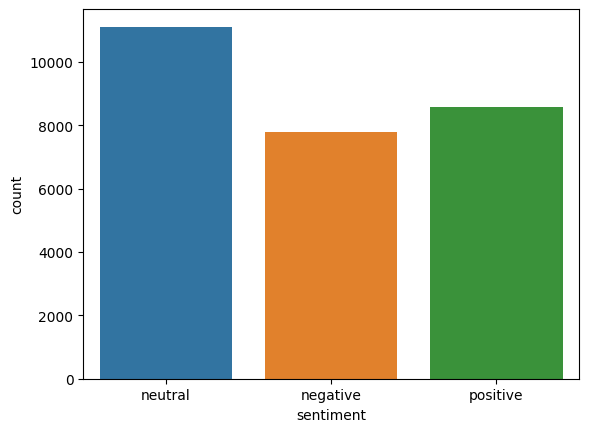

In [8]:
import seaborn as sns
sns.countplot(data=tweets_data,x="sentiment")

In [9]:
tweets_data["word_count"] = tweets_data["text"].apply(lambda x: len(str(x).split()))
tweets_data[["text", "word_count"]].sample(10)


,text,word_count
20082,"cool, not a big user of DM though",8
11609,Cloudy today,2
15918,Sittting in my seat watching the tyra show,8
17551,"My feet are killing, I`ve walked miles in sear...",18
9745,Another interview... Please somebody hire me?!...,9
8800,have you read Angels & Demons? What do you th...,23
7390,"awesome milkshakes, i had areo mint,. we just ...",26
616,"either way, you always tend to make my #follo...",17
8155,aww dude.. no fair. i thought that was the poi...,13
10687,I love my Boogah! Can anyone contain Lebron Ja...,13


In [10]:
tweets_data.groupby("sentiment")["word_count"].mean()

sentiment
negative    13.473204
neutral     12.343888
positive    13.109881
Name: word_count, dtype: float64

<AxesSubplot: xlabel='word_count', ylabel='Count'>

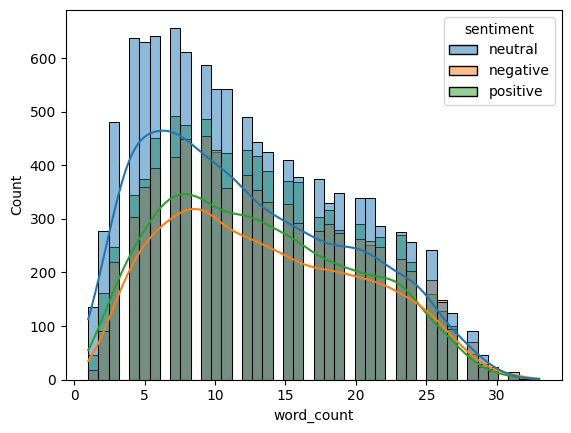

In [11]:
sns.histplot(data = tweets_data, x="word_count",hue="sentiment",kde= True)

In [12]:
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = stopwords.words("english")

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
import string
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)

    stripped_urls = tf.strings.regex_replace(lowercase,r"https?://\S+|www\.S+","")
    

    stripped_symbol = tf.strings.regex_replace(stripped_urls,"\S+@\S+\s?","")

    stripped_brackets =tf.strings.regex_replace(stripped_symbol,"<.*?>+","")

    stripped_brackets =tf.strings.regex_replace(stripped_brackets,"\[|\]","")
    stripped_digits =tf.strings.regex_replace(stripped_brackets,"\w*\d\w*","")

    stripped_stopwords = tf.strings.regex_replace(stripped_digits,r"\b(?:{})\b".format("|".join(stop_words)),"")

    striped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords,"\s+"," ")

    return tf.strings.regex_replace(striped_whitespace_chars,r"[^a-zA-Z\s]+","")

In [14]:
tweets_data["text"][11827]
custom_standardization(tweets_data["text"][11827]).numpy()

b' degree tear happy moment '

In [15]:
tweets_data["cleaned_text"]=tweets_data["text"].apply(custom_standardization)
tweets_data

,textID,text,selected_text,sentiment,word_count,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,"tf.Tensor(b' responded going', shape=(), dtyp..."
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,"tf.Tensor(b' sooo sad miss san diego', shape=(..."
2,088c60f138,my boss is bullying me...,bullying me,negative,5,"tf.Tensor(b' boss bullying ', shape=(), dtype=..."
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,"tf.Tensor(b' interview leave alone', shape=(),..."
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,tf.Tensor(b' sons put releases already bough...
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16,tf.Tensor(b' wish could come see u denver husb...
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23,tf.Tensor(b' wondered rake client made clear...
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22,tf.Tensor(b' yay good enjoy break probably n...
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6,"tf.Tensor(b' worth ', shape=(), dtype=string)"


In [16]:
def tensor_to_string(tensor):
    return tensor.numpy().decode("utf-8")
tweets_data["cleaned_text"]= tweets_data["cleaned_text"].apply(tensor_to_string)
tweets_data


,textID,text,selected_text,sentiment,word_count,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,5,boss bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,sons put releases already bought
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16,wish could come see u denver husband lost job...
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23,wondered rake client made clear net force...
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22,yay good enjoy break probably need hectic w...
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6,worth


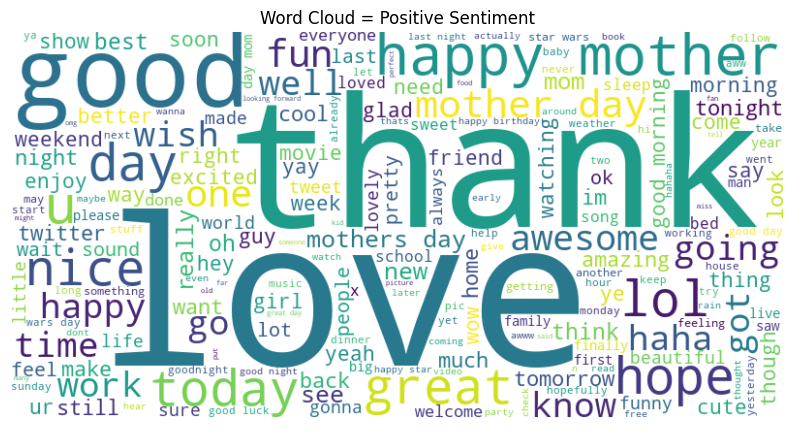

In [17]:
positive_tweets = tweets_data[tweets_data["sentiment"]=="positive"]["cleaned_text"]

positive_text=" ".join(positive_tweets)

wordcloud = WordCloud(width = 800,height = 400,background_color="white").generate(positive_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud = Positive Sentiment")
plt.show()

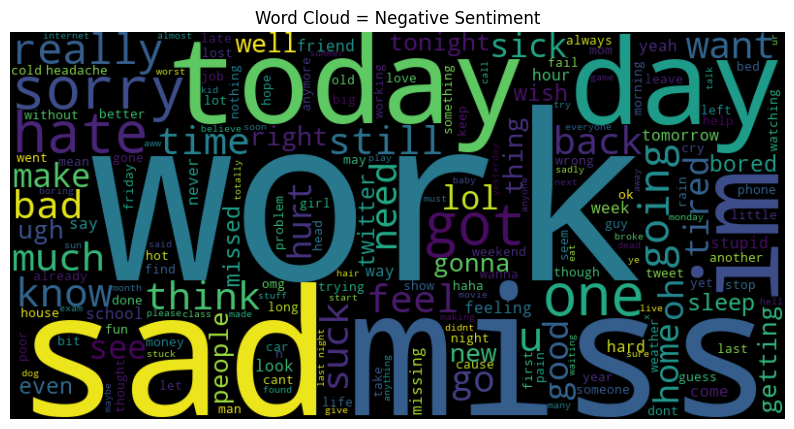

In [18]:
negative_tweets = tweets_data[tweets_data["sentiment"]=="negative"]["cleaned_text"]

negative_text=" ".join(negative_tweets)

wordcloud = WordCloud(width = 800,height = 400,background_color="black").generate(negative_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud = Negative Sentiment")
plt.show()

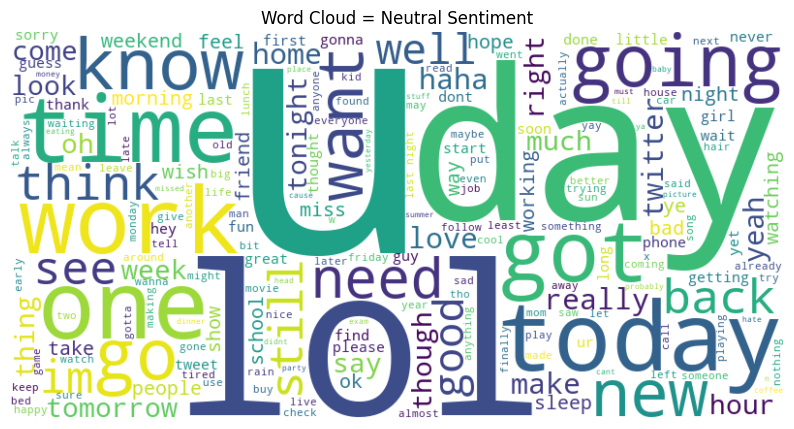

In [19]:
neutral_tweets = tweets_data[tweets_data["sentiment"]=="neutral"]["cleaned_text"]

neutral_text=" ".join(neutral_tweets)

wordcloud = WordCloud(width = 800,height = 400,background_color="white").generate(neutral_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud = Neutral Sentiment")
plt.show()

In [20]:
tweets_data["sentiment"]= tweets_data["sentiment"].replace({
    "negative" :0,
    "neutral":1,
    "positive":2
})
tweets_data.sample(10)

,textID,text,selected_text,sentiment,word_count,cleaned_text
24004,5c3831e16a,another david hughes on your list? I`m hurt ...,I`m hurt,0,9,another david hughes list hurt ftw
13557,407d628039,is cute,is cute,2,2,cute
5262,6015712a8c,As long as you take me with you,As long as you take me with you,1,8,long take
23356,8f6d00e076,"I miss ya, Boyfriend! When am I gonna see ya ...",miss,0,12,miss ya boyfriend gonna see ya brtt
20596,0b02961cfa,"i did, thanks laura",thanks,2,4,thanks laura
22928,3c68f6963c,"lol, on blip.fm is not the on twitter! i ha...",r! i hate that son,0,13,lol blipfm twitter hate song btw
1623,2dc0b560b5,copy & paste **** **** tosser piss flap a 100...,copy & paste **** **** tosser piss flap a 1000...,0,12,copy paste tosser piss flap times
4369,ff207f2540,More to thank for #ff shouts and heaps mor...,More to thank for #ff shouts and heaps mor...,1,18,thank ff shouts heaps sry night realise
1136,3113132bb5,thanks lyxxx,thanks,2,2,thanks lyxxx
17562,a3df1afdb7,Nothing like Charley Biggs Chicken @ 7:53AM,Nothing like Charley Biggs Chicken @ 7:53AM,1,7,nothing like charley biggs chicken


In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test = train_test_split(tweets_data,test_size=0.2,stratify=tweets_data["sentiment"],random_state=123)
x_train,x_val = train_test_split(x_train,test_size=0.1,stratify=x_train["sentiment"],random_state=123)
x_train.shape,x_val.shape, x_test.shape

((19785, 6), (2199, 6), (5496, 6))

In [26]:
x_test["sentiment"].value_counts()

1    2223
2    1717
0    1556
Name: sentiment, dtype: int64

In [27]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train["text"].values,x_train["sentiment"].values)).shuffle(1024).batch(batch_size=128)
raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (x_val["text"].values,x_val["sentiment"].values)).batch(batch_size=128)
raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test["text"].values,x_test["sentiment"].values)).batch(batch_size=128)


len(raw_train_ds),len(raw_test_ds),len(raw_val_ds)

(155, 43, 18)

In [30]:
vocab_size = 30

count_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode="count"
)

In [33]:
text=["Malcolm is an amazing painter.Malcom also loves watching cricket","Dean cooks well",
      "Malcolm is a decent footballer too",
      "Chris is a teacher, he is quite experienced in teaching"]
count_vectorizer.adapt(text)
count_vectorizer.get_vocabulary()

['[UNK]',
 'is',
 'malcolm',
 'a',
 'well',
 'watching',
 'too',
 'teaching',
 'teacher',
 'quite',
 'paintermalcom',
 'loves',
 'in',
 'he',
 'footballer',
 'experienced',
 'decent',
 'dean',
 'cricket',
 'cooks',
 'chris',
 'an',
 'amazing',
 'also']

In [34]:
count_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=float32, numpy=
array([[0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

In [35]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode="count",
    ngrams=(1,2)
)

In [36]:
train_text = raw_test_ds.map(lambda x,y:x)
count_vectorizer.adapt(train_text)

In [ ]:
def vectorize_text(text,label):
    text = tf.expand_dims(text,-1)

    return count_vectorizer(text),label